In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [53]:
# Load initial load values from CSV using Pandas
data = pd.read_csv('InputMicrogrid.csv')
time = data['Time'].values
loaddemand = data['LoadDemand'].values
PVpower = data['PVPower'].values*10000
loadforecast = data['LoadForecast'].values

# Determine the number of iterations
num_iterations = len(loaddemand)
num_days = num_iterations // 24

# Create pbess and soc arrays with initial values
pbess = np.zeros(num_iterations + 1)
soc = np.zeros(num_iterations + 1)

amountdischarge = np.round(np.zeros(num_iterations + 1), 2)
amountcharge = np.round(np.zeros(num_iterations + 1), 2)
batterysupply = np.round(np.zeros(num_iterations + 1), 2)
gridsupply = np.round(np.zeros(num_iterations + 1), 2)
is_peak = np.zeros(num_iterations + 1, dtype=bool)
cost = np.round(np.zeros(num_iterations + 1), 2)

soc[0] = 0.6
socmin = 0.2
socmax = 0.8
dischargemaxlimit = 48000
chargemaxlimit = 48000
batterycapacity = 50000
batterycapacitymin = batterycapacity * socmin
batterycapacitymax = batterycapacity * socmax

pbess[0] = batterycapacity * soc[0]

price_peak = 36.5
price_nonpeak = 22.4

In [54]:
# Determine peak times
for i in range(num_iterations):
    if 8 <= time[i] < 22:
        is_peak[i] = True

is_discharging = False  # Initialize discharging flag

In [55]:
def discharge(pbess, i):
    global is_discharging
    amountdischarge = min(loaddemand[i], dischargemaxlimit, (pbess[i] - batterycapacitymin))
    pbess[i + 1] = pbess[i] - amountdischarge
    soc[i + 1] = np.round(pbess[i + 1] / batterycapacity, 2)
    if soc[i + 1] <= socmin:
        is_discharging = False
    return amountdischarge

# Define the charge function
def charge(pbess, i):
    global is_discharging
    amountcancharge = min(PVpower[i], chargemaxlimit, batterycapacitymax - pbess[i])
    pbess[i + 1] = pbess[i] + amountcancharge
    soc[i + 1] = np.round(pbess[i + 1] / batterycapacity, 2)
    if soc[i + 1] >= socmax:
        is_discharging = True
    return amountcancharge

In [56]:
# main loop 
for day in range(num_days):
    start_idx = day * 24
    end_idx = start_idx + 24
    is_discharging = True
    for i in range(start_idx, end_idx):
        if is_peak[i]:
            if is_discharging or PVpower[i]==0:
                batterysupply[i] = discharge(pbess, i)
                gridsupply[i] = loaddemand[i] - batterysupply[i]
                cost[i] = gridsupply[i] * 36.5
            else:  # Charge if not discharging or if soc reaches socmin
                amountcharge[i] = charge(pbess, i)
                gridsupply[i] = loaddemand[i]
                cost[i] = gridsupply[i] * 36.5
        else:  # Non-peak hours
            amountcharge[i] = charge(pbess, i)
            gridsupply[i] = loaddemand[i]
            cost[i] = gridsupply[i] * 22.4


In [57]:
# Print results
print("    h   | PBESS    |   SOC    | PV POWER | LOAD DEMAND | BATTERY SUPPLY    |   GRID SUPPLY   |  AMOUNT CHARGE ")
print("--------------------------------------------------------------------------------------------------------------")
for i in range(0,24):
    print(f"{time[i]:3.0f} | {pbess[i]:10.2f}   |  {soc[i]:10.2f}   |  {PVpower[i]:10.2f}   | {loaddemand[i]:10.2f}   | {batterysupply[i]:10.2f}   |   {gridsupply[i]:10.2f}    |   {amountcharge[i]:10.2f}")

    h   | PBESS    |   SOC    | PV POWER | LOAD DEMAND | BATTERY SUPPLY    |   GRID SUPPLY   |  AMOUNT CHARGE 
--------------------------------------------------------------------------------------------------------------
  1 |   30000.00   |        0.60   |        0.00   |     514.24   |       0.00   |       514.24    |         0.00
  2 |   30000.00   |        0.60   |        0.00   |     514.24   |       0.00   |       514.24    |         0.00
  3 |   30000.00   |        0.60   |        0.00   |     514.24   |       0.00   |       514.24    |         0.00
  4 |   30000.00   |        0.60   |        0.00   |     514.24   |       0.00   |       514.24    |         0.00
  5 |   30000.00   |        0.60   |        0.00   |     526.46   |       0.00   |       526.46    |         0.00
  6 |   30000.00   |        0.60   |        0.00   |     600.75   |       0.00   |       600.75    |         0.00
  7 |   30000.00   |        0.60   |     5420.00   |     874.90   |       0.00   |       874.9

In [58]:
#Get the result for daily cost, grid supply and battery supply
daily_cost = [np.sum(cost[i:i+24]) for i in range(0, num_iterations, 24)]
daily_grid_supplies = [np.sum(gridsupply[i:i+24]) for i in range(0, num_iterations, 24)]
daily_battery_supplies = [np.sum(batterysupply[i:i+24]) for i in range(0, num_iterations, 24)]
days = np.arange(1, num_days + 1)

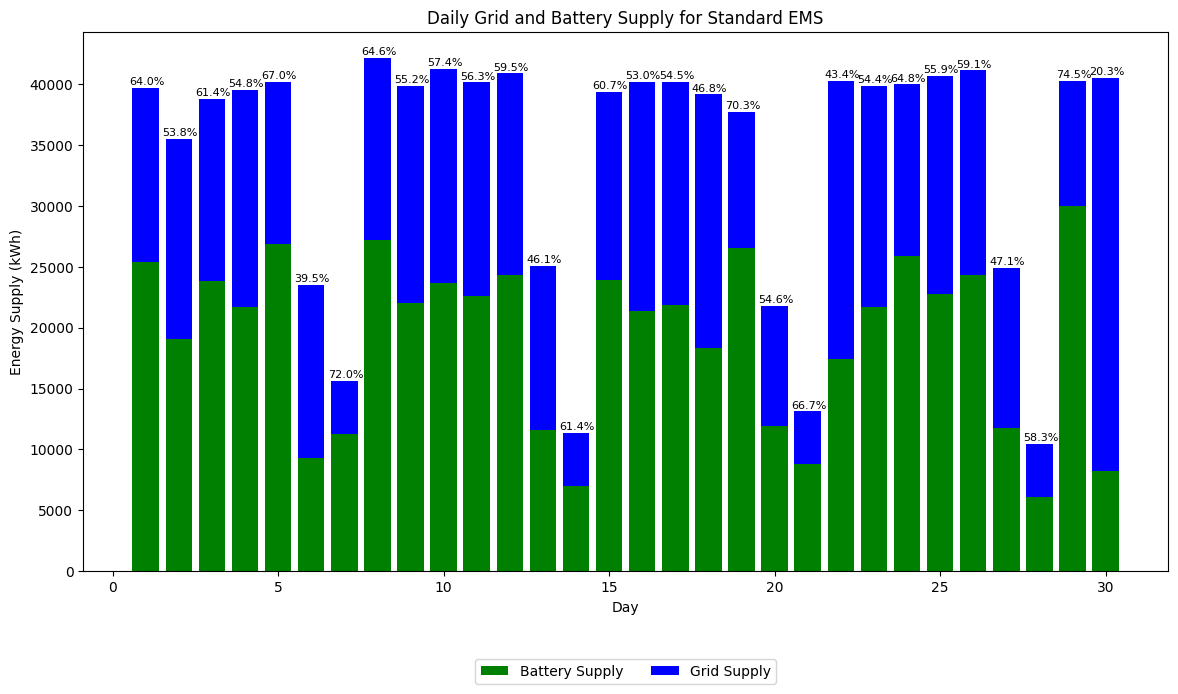

In [59]:
#Plot bar graph of daily grid supply and battery supply
battery_supply_percentages = np.round(np.array(daily_battery_supplies) / (np.array(daily_grid_supplies) + np.array(daily_battery_supplies))* 100,1)
  
plt.figure(figsize=(14, 7))
plt.bar(days,daily_battery_supplies, color = 'g')
plt.bar(days,daily_grid_supplies, bottom=daily_battery_supplies,color = 'b')
plt.title('Daily Grid and Battery Supply for Standard EMS')
plt.ylabel('Energy Supply (kWh)')
plt.xlabel('Day')

for i, v in enumerate(battery_supply_percentages):
    height = daily_battery_supplies[i] + daily_grid_supplies[i]
    plt.text(days[i] - 0.5, height+250, str(v)+'%',fontsize=8)
    
plt.legend(['Battery Supply', 'Grid Supply'],loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)

    
plt.show()



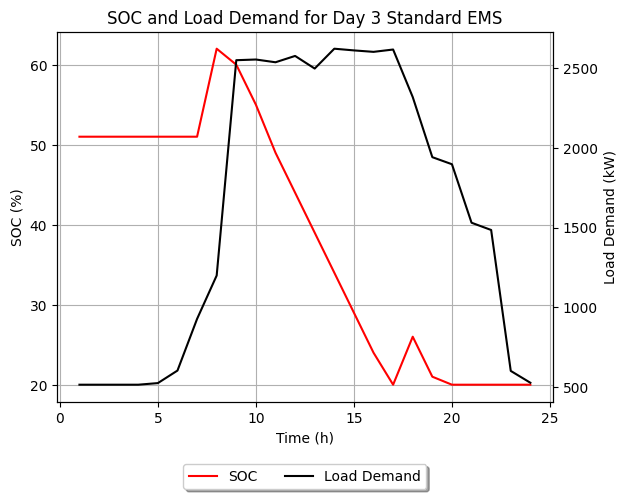

In [60]:
#Plot SOC and Load Demand

# Define the index range for day 3
day = 3
start_idx_day = (day - 1) * 24
end_idx_day = start_idx_day + 24

#Define the time for X and Y axis
x = time[start_idx_day:end_idx_day]
y1 = (soc[start_idx_day:end_idx_day])*100
y2 = loaddemand[start_idx_day:end_idx_day]

#Plot the graph
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(True)  

ax1.plot(x, y1, label='SOC', color='r')
ax1.set_ylabel('SOC (%)')
ax2.plot(x, y2, label='Load Demand',color='k')
ax2.set_ylabel('Load Demand (kW)')
ax1.set_xlabel('Time (h)')

# Add legends below the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.title('SOC and Load Demand for Day 3 Standard EMS')
plt.show()

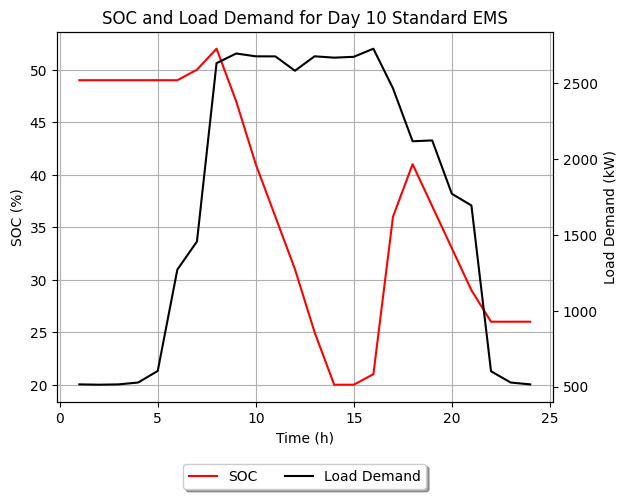

In [64]:
#Plot SOC and Load Demand

# Define the index range for day 3
day = 10
start_idx_day = (day - 1) * 24
end_idx_day = start_idx_day + 24

#Define the time for X and Y axis
x = time[start_idx_day:end_idx_day]
y1 = (soc[start_idx_day:end_idx_day])*100
y2 = loaddemand[start_idx_day:end_idx_day]

#Plot the graph
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(True)  

ax1.plot(x, y1, label='SOC', color='r')
ax1.set_ylabel('SOC (%)')
ax2.plot(x, y2, label='Load Demand',color='k')
ax2.set_ylabel('Load Demand (kW)')
ax1.set_xlabel('Time (h)')

# Add legends below the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.title('SOC and Load Demand for Day 10 Standard EMS')
plt.show()

In [61]:
#Calculate total cost for the month
total_cost = np.sum(cost)/100
total_cost_peak = np.sum(cost[is_peak])/100
total_cost_nonpeak = np.sum(cost[~is_peak])/100

print(f"Total cost for the month: RM{total_cost:.2f}")
print(f"Total cost for the month non peak: RM{total_cost_peak:.2f}")
print(f"Total cost for the month non peak: RM{total_cost_nonpeak:.2f}")

Total cost for the month: RM137257.12
Total cost for the month non peak: RM96289.45
Total cost for the month non peak: RM40967.67


In [62]:
# Define the file path
file_path = "TraditionalEMSResult.csv"

# Write the total costs to the CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Day", "Total Cost"])  # Write the header
    for day, cost in enumerate(daily_cost, start=1):
        writer.writerow([day, cost])